# **Dados do Indice IBOVESPA B3**

## **O problema**

Você foi recentemente alocado em uma equipe de cientistas de dados de um grande fundo de investimentos brasileiro. Sua missão inicial é desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice. Esse modelo será usado como insumo para alimentar dashboards internos de tomada de decisão dos analistas quantitativos da empresa.

### **Dados**

Utilize os dados históricos do índice IBOVESPA, disponíveis publicamente: https://br.investing.com/indices/bovespa-historical-data
Requisitos:  
• Selecione o período “diário”.  
• Baixe um intervalo de pelo menos 2 anos de dados.  
• Realize o pré-processamento necessário para utilizar os dados no modelo.

### **Objetivo**

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:
Tech challenge Página 3 de 5.  
Seu modelo deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste. O conjunto de testes deverá conter o último mês (30 dias) de dados disponíveis.

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

sns.set_style()

In [213]:
#url = "https://raw.githubusercontent.com/JacksonvBarbosa/Analise_Indice_Ibovespa/refs/heads/sofia/data/Dados_Historicos_Ibovespa_2008-2025.csv."
# df_ibov = pd.read_csv(url, sep=",",thousands='.', decimal=',', parse_dates=['Data'], date_format='%d.%m.%Y', index_col='Data')
#df_ibov = pd.read_csv(url_2008_2025, parse_dates=['Data'], index_col='Data', dayfirst=True)

In [214]:
df_ibov = pd.read_csv("C:/Users/wbaldin/Downloads/Dados_Historicos_Ibovespa_2008-2025.csv", thousands='.', decimal=',', parse_dates=['Data'], date_format='%d.%m.%Y', index_col='Data')
df_ibov.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2025-06-18,138717,138844,139161,138443,"8,32B","-0,09%"
2025-06-17,138840,139256,139497,138293,"8,38B","-0,30%"
2025-06-16,139256,137212,139988,137212,"7,62B","1,49%"
2025-06-13,137213,137800,137800,136586,"8,63B","-0,43%"
2025-06-12,137800,137127,137931,136175,"7,12B","0,49%"


In [215]:
df_ibov.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2025-06-18,138717,138844,139161,138443,"8,32B","-0,09%"
2025-06-17,138840,139256,139497,138293,"8,38B","-0,30%"
2025-06-16,139256,137212,139988,137212,"7,62B","1,49%"
2025-06-13,137213,137800,137800,136586,"8,63B","-0,43%"
2025-06-12,137800,137127,137931,136175,"7,12B","0,49%"


In [216]:
df_ibov_copia = df_ibov.copy()
df_ibov_copia

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2025-06-18,138717,138844,139161,138443,"8,32B","-0,09%"
2025-06-17,138840,139256,139497,138293,"8,38B","-0,30%"
2025-06-16,139256,137212,139988,137212,"7,62B","1,49%"
2025-06-13,137213,137800,137800,136586,"8,63B","-0,43%"
2025-06-12,137800,137127,137931,136175,"7,12B","0,49%"
...,...,...,...,...,...,...
2008-01-24,57463,54242,57675,54242,"3,80M","5,95%"
2008-01-23,54235,56098,56098,53011,"3,72M","-3,32%"
2008-01-22,56097,53705,56541,53610,"3,65M","4,45%"


In [217]:
display(df_ibov_copia.info())
display(df_ibov_copia.shape)
display(df_ibov_copia.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4315 entries, 2025-06-18 to 2008-01-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Último    4315 non-null   int64 
 1   Abertura  4315 non-null   int64 
 2   Máxima    4315 non-null   int64 
 3   Mínima    4315 non-null   int64 
 4   Vol.      4314 non-null   object
 5   Var%      4315 non-null   object
dtypes: int64(4), object(2)
memory usage: 236.0+ KB


None

(4315, 6)

,Último,Abertura,Máxima,Mínima
count,4315.000000,4315.000000,4315.000000,4315.000000
mean,79352.197683,79333.994206,80080.700116,78597.684125
std,28359.063927,28346.475663,28473.375462,28232.454664
min,29435.000000,29438.000000,31480.000000,29435.000000
25%,55813.500000,55811.000000,56409.500000,55244.000000
50%,67766.000000,67756.000000,68198.000000,67191.000000
75%,106349.000000,106317.000000,107413.500000,105307.500000
max,140110.000000,140109.000000,140382.000000,138966.000000


<Axes: xlabel='Data', ylabel='Último'>

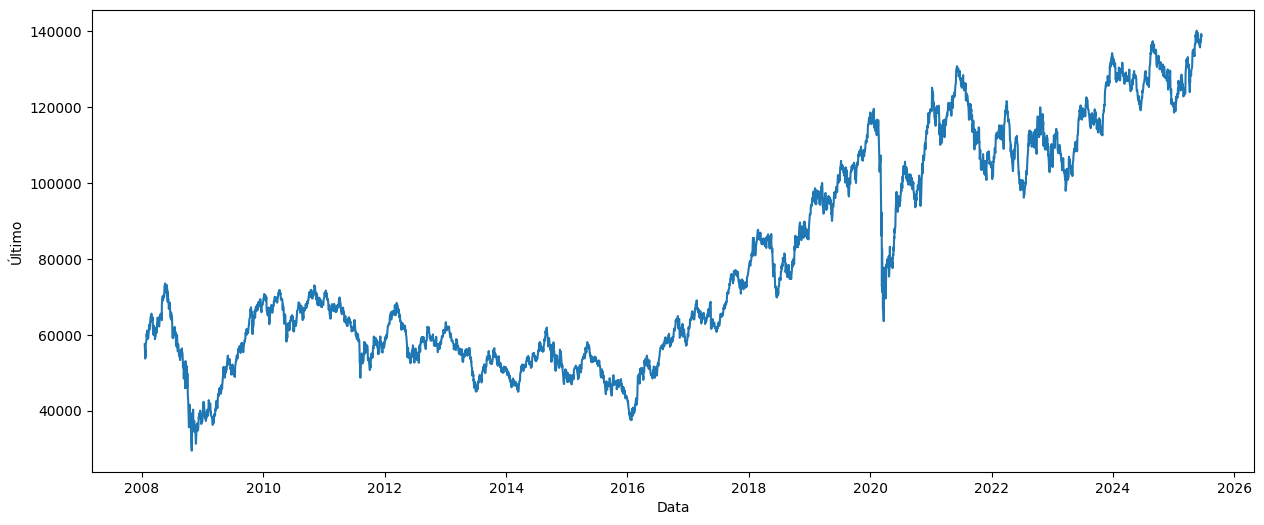

In [218]:
plt.figure(figsize=(15, 6))
sns.lineplot(x=df_ibov_copia.index, y=df_ibov_copia['Último'])

<Axes: title={'center': 'Índice Bovespa - Último Preço'}, xlabel='Data'>

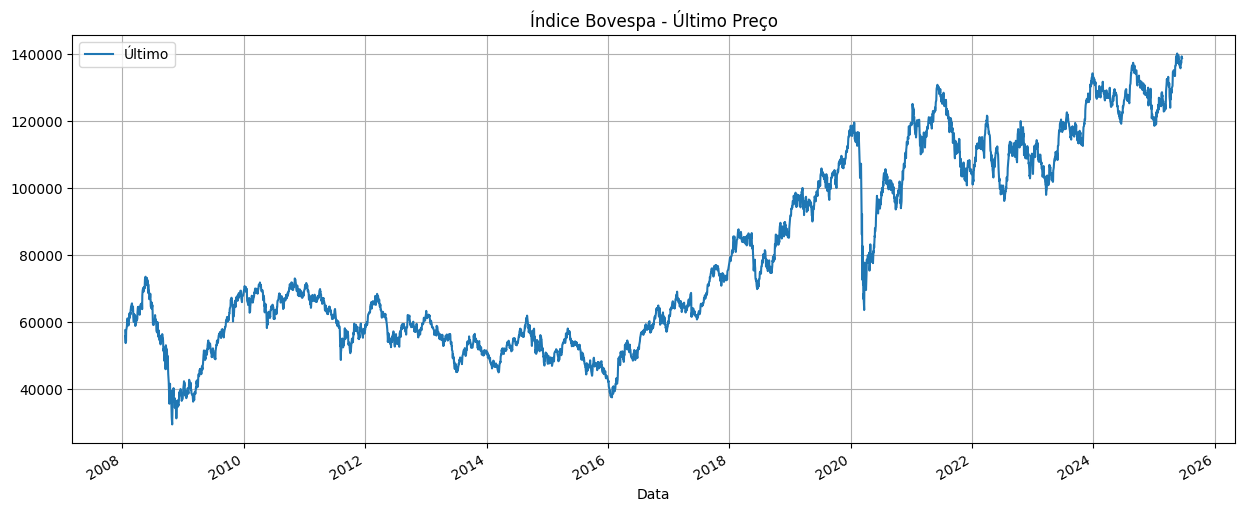

In [219]:
df_ibov_copia.plot(figsize=(15, 6), y='Último', title='Índice Bovespa - Último Preço', grid=True)

In [220]:
df_ibov_copia.plot(figsize=(15, 6), y='SARIMA', title='Índice Bovespa - SARIMA', grid=True)

KeyError: 'SARIMA'

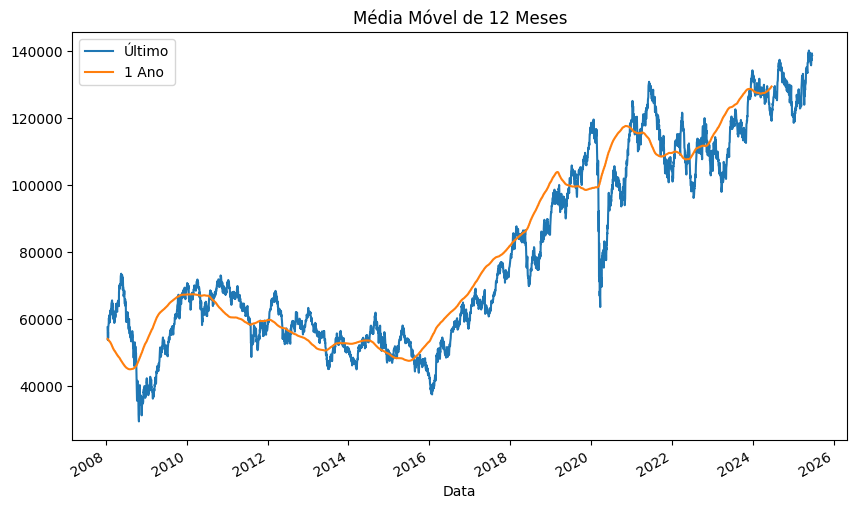

In [221]:
df_ibov_copia["1 Ano"] = df_ibov_copia["Último"].rolling(window=252).mean()
df_ibov_copia[["Último", "1 Ano"]].plot(title="Média Móvel de 12 Meses", figsize=(10, 6))
plt.show()

In [222]:
ts.head()

,Último,ARIMA
Data,,
2025-06-18,138717,NaN
2025-06-17,138840,NaN
2025-06-16,139256,NaN
2025-06-13,137213,NaN
2025-06-12,137800,NaN


In [223]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustando o modelo ARIMA
model = ARIMA(ts["Último"], order=(5, 1, 0))
model_fit = model.fit()
ts["ARIMA"] = model_fit.predict(start=1, end=len(ts), typ="levels")



C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  

C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  

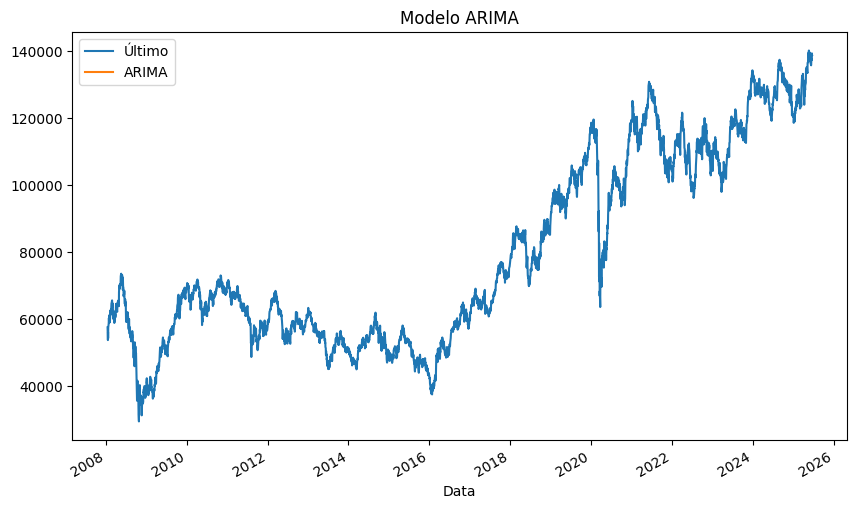

In [224]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustando o modelo ARIMA
model = ARIMA(df_ibov_copia["Último"], order=(5, 1, 0))
model_fit = model.fit()
df_ibov_copia["ARIMA"] = model_fit.predict(start=1, end=len(df_ibov_copia), typ="levels")

# Plotando os resultados
df_ibov_copia[["Último", "ARIMA"]].plot(title="Modelo ARIMA", figsize=(10, 6))
plt.show()

In [235]:
df_ibov_copia

,Último,Abertura,Máxima,Mínima,Vol.,Var%,1 Ano,ARIMA,SARIMA,Fechamento
Data,,,,,,,,,,
2025-06-18,138717,138844,139161,138443,8.320000e+11,-0.09,NaN,NaN,NaN,1
2025-06-17,138840,139256,139497,138293,8.380000e+11,-0.30,NaN,NaN,138716.995388,1
2025-06-16,139256,137212,139988,137212,7.620000e+11,1.49,NaN,NaN,138840.004344,0
2025-06-13,137213,137800,137800,136586,8.630000e+11,-0.43,NaN,NaN,139255.995901,1
2025-06-12,137800,137127,137931,136175,7.120000e+11,0.49,NaN,NaN,137213.003922,0
...,...,...,...,...,...,...,...,...,...,...
2008-01-24,57463,54242,57675,54242,3.800000e+08,5.95,53788.698413,NaN,58881.690868,0
2008-01-23,54235,56098,56098,53011,3.720000e+08,-3.32,53844.285714,NaN,57714.361631,1
2008-01-22,56097,53705,56541,53610,3.650000e+08,4.45,53913.325397,NaN,53969.564227,0


C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  

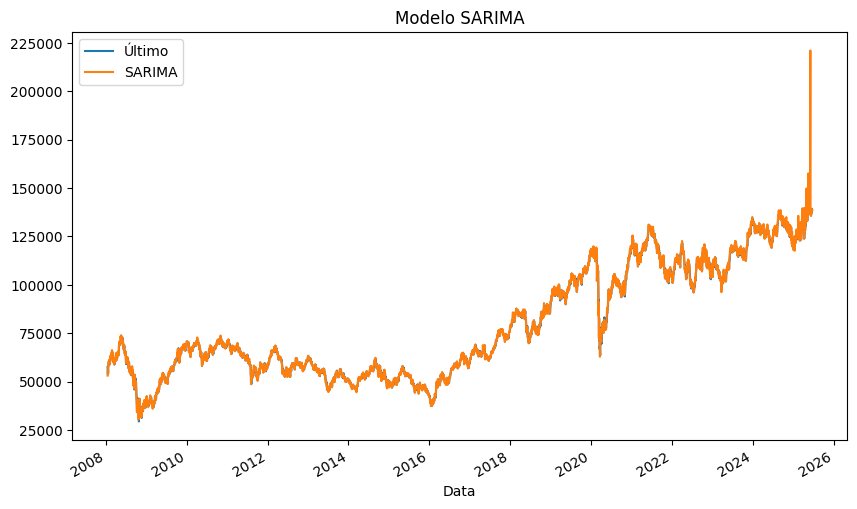

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustando o modelo SARIMA
model = SARIMAX(df_ibov_copia["Último"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)
df_ibov_copia["SARIMA"] = model_fit.predict(start=1, end=len(df_ibov_copia)-1)

# Plotando os resultados
df_ibov_copia[["Último", "SARIMA"]].plot(title="Modelo SARIMA", figsize=(10, 6))
plt.show()


C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\wbaldin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  

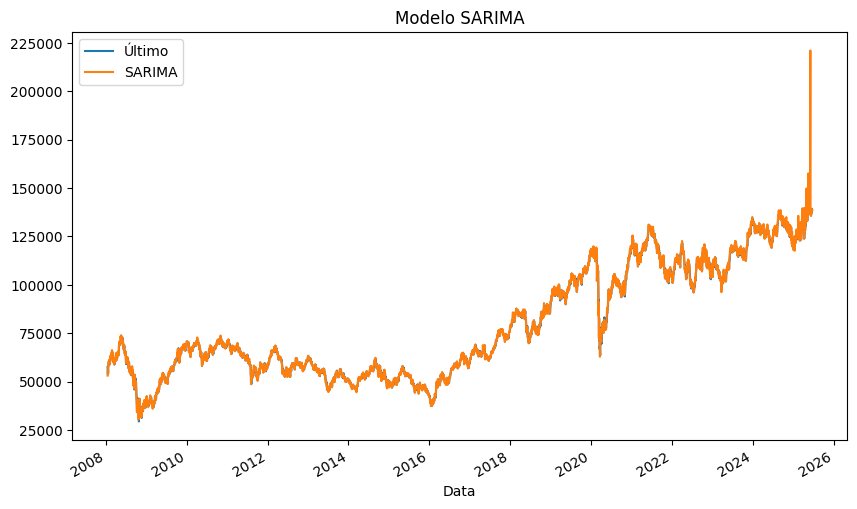

In [237]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustando o modelo SARIMA
model = SARIMAX(df_ibov_copia["Último"], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)
df_ibov_copia["SARIMA"] = model_fit.predict(start=1, end=len(df_ibov_copia)-1)

# Plotando os resultados
df_ibov_copia[["Último", "SARIMA"]].plot(title="Modelo SARIMA", figsize=(10, 6))
plt.show()

In [226]:
df_ibov_copia

,Último,Abertura,Máxima,Mínima,Vol.,Var%,1 Ano,ARIMA,SARIMA
Data,,,,,,,,,
2025-06-18,138717,138844,139161,138443,"8,32B","-0,09%",NaN,NaN,NaN
2025-06-17,138840,139256,139497,138293,"8,38B","-0,30%",NaN,NaN,138716.995388
2025-06-16,139256,137212,139988,137212,"7,62B","1,49%",NaN,NaN,138840.004344
2025-06-13,137213,137800,137800,136586,"8,63B","-0,43%",NaN,NaN,139255.995901
2025-06-12,137800,137127,137931,136175,"7,12B","0,49%",NaN,NaN,137213.003922
...,...,...,...,...,...,...,...,...,...
2008-01-24,57463,54242,57675,54242,"3,80M","5,95%",53788.698413,NaN,58881.690868
2008-01-23,54235,56098,56098,53011,"3,72M","-3,32%",53844.285714,NaN,57714.361631
2008-01-22,56097,53705,56541,53610,"3,65M","4,45%",53913.325397,NaN,53969.564227


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(teste, previsoes_media)
rmse = np.sqrt(mean_squared_error(teste, previsoes_media))

In [227]:
ts

,Último,ARIMA
Data,,
2025-06-18,138717,NaN
2025-06-17,138840,NaN
2025-06-16,139256,NaN
2025-06-13,137213,NaN
2025-06-12,137800,NaN
...,...,...
2008-01-24,57463,NaN
2008-01-23,54235,NaN
2008-01-22,56097,NaN


<Axes: >

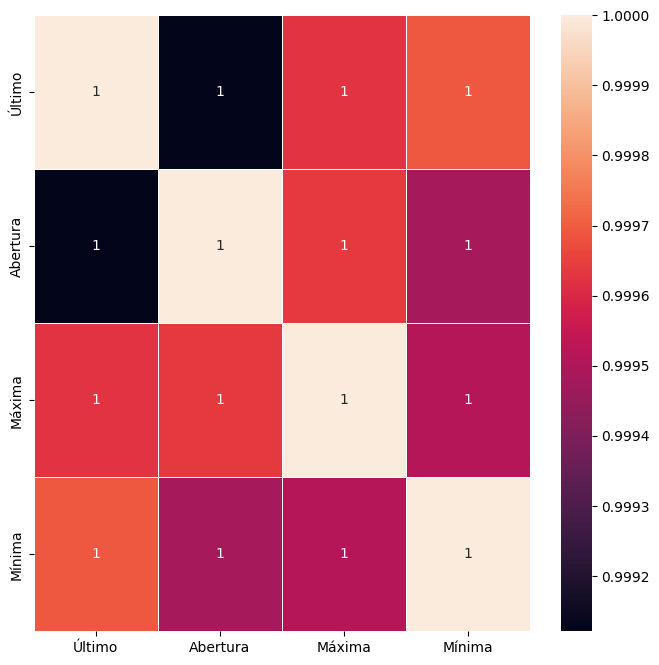

In [228]:

correlation_matrix = df_ibov.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.7, ax=ax)


In [229]:
df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4315 entries, 2025-06-18 to 2008-01-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Último    4315 non-null   int64 
 1   Abertura  4315 non-null   int64 
 2   Máxima    4315 non-null   int64 
 3   Mínima    4315 non-null   int64 
 4   Vol.      4314 non-null   object
 5   Var%      4315 non-null   object
dtypes: int64(4), object(2)
memory usage: 236.0+ KB


In [230]:
def converter_volume(vol):
    if pd.isna(vol):
        return np.nan
    vol = vol.upper().replace(',', '').strip()
    if vol.endswith('B'):
        return float(vol[:-1]) * 1e9
    elif vol.endswith('M'):
        return float(vol[:-1]) * 1e6
    elif vol.endswith('K'):
        return float(vol[:-1]) * 1e3
    else:
        return float(vol)
        
df_ibov_copia['Vol.'] = df_ibov_copia['Vol.'].apply(converter_volume)

### Criar uma caracteristica (coluna) de fechamento positivo(1) ou negativo(0) utilizando a caracteristica [Último] como referência

In [231]:
df_ibov_copia['Var%'] = df_ibov_copia['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

In [232]:
print(df_ibov_copia[['Vol.', 'Var%']].dtypes)
print(df_ibov_copia[['Vol.', 'Var%']].head())

Vol.    float64
Var%    float64
dtype: object
                    Vol.  Var%
Data                          
2025-06-18  8.320000e+11 -0.09
2025-06-17  8.380000e+11 -0.30
2025-06-16  7.620000e+11  1.49
2025-06-13  8.630000e+11 -0.43
2025-06-12  7.120000e+11  0.49


In [233]:
'''Exemplo do metodo Shift ele irá varrer o data frame e conforme o parametro colocado nele ele irá fazer o deslocamento
para linha seguinte ou anterior
Ex.: Shift(n) -> Compara valores anteriores (n>0)
     Shift(n) -> Compara valores seguintes (n<0) Vamos usar este para buscar valores seguintes
     Shift(n) -> Compara com o dia anterior (n=1)

''' 
# Exemplos de uso
df = pd.DataFrame({'Preço': [100, 102, 101, 105]})
df['Anterior'] = df['Preço'].shift(1)
df['Seguinte'] = df['Preço'].shift(-1)

df

,Preço,Anterior,Seguinte
0,100,NaN,102.0
1,102,100.0,101.0
2,101,102.0,105.0
3,105,101.0,NaN


In [234]:
df_ibov_copia['Fechamento'] = (df_ibov['Último'].shift(-1) > df_ibov['Último']).astype('Int64')